## Topic Modelling


####  Functions to support text analytics of imdb reviews


In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from ggplot import *
import unicodedata
from textblob import TextBlob
import nltk
from itertools import izip
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

%matplotlib inline 
matplotlib.style.use('ggplot') 

In [2]:
# Modules to support text analytics 

def requestPage(url): 
    try:
        response = requests.get(url)  
        page  = BeautifulSoup(response.text, 'html.parser')
        return page
        
    except(ConnectionError, Exception), e:
        print "Exception is :", e

        
def extractRatings(page,i):
    data_rating = {}
    i = i + 1 
    for b in page.select('div[id="tn15content"] img'):
        rating = b.get("alt")
        if rating is not None and rating != u"[Next]" and rating != u"[Prev]":
            data_rating.update({i:rating.encode('utf-8')})
            i = i + 1
    return data_rating

def extractReviews(page,i):
    data_review = {}
    i = i + 1 
    for a in page.select('div[id="tn15content"] p'):
        review = a.get_text().replace("\n"," ").replace("*** This review may contain spoilers ***", "IGNORE").replace("Add another review","IGNORE")
        if review != "IGNORE":
            data_review.update({i:review.encode('utf-8')})
            i = i + 1 
    return data_review

def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

### Extract IMDB movie reviews ( 50 positive , 50 negative ) for movie = Titanic ( 1997 ) 
   http://www.imdb.com/title/tt0120338/
    

In [3]:
# Movie name = Up

p_url = "http://www.imdb.com/title/tt0120338/reviews?filter=love;filter=love;start=" # positive reviews link
n_url = "http://www.imdb.com/title/tt0120338/reviews?filter=hate;filter=hate;start=" # negative reviews link

# DataFrame for all extracted reviews
imdb = pd.DataFrame()

# Pagination for 50 reviews 
pagination = [0,10,20,30,40] # pagination for imdb pagination to get top 50 reviews in a category 

for counter in pagination:

    positive_url = p_url + str(counter)
    negative_url = n_url + str(counter)
    
    # Request url for reviews 
    responses_positive = requestPage(positive_url)
    responses_negative = requestPage(negative_url)
    
    # Extract ratings and reviews 
    ratings_positive  = extractRatings(responses_positive,counter)    
    reviews_positive  = extractReviews(responses_positive,counter)
    
    ratings_negative  = extractRatings(responses_negative,counter+50)
    reviews_negative  = extractReviews(responses_negative,counter+50)
    
    # Copy the extracted data into dataframes
    df_p = pd.DataFrame(columns=['ratings','reviews'])
    df_p = pd.DataFrame([ratings_positive,reviews_positive]).T
    
    df_n = pd.DataFrame(columns=['ratings','reviews'])
    df_n = pd.DataFrame([ratings_negative,reviews_negative]).T
    
    # Create master dataframe for text analytics 
    imdb = imdb.append([df_p,df_n])
    
print "\n Extracted ratings & reviews"


 Extracted ratings & reviews


In [4]:
imdb.head()

Empty DataFrame
Columns: [0, 1]
Index: []

In [6]:
imdb.columns = ['ratings', 'reviews']
imdb = imdb.sort_index()
print imdb.head(10)
print imdb.tail(10)

   ratings                                            reviews
1    10/10   Every once in a while the conversation will t...
2    10/10    To all the miserable people who have done ev...
3    10/10    I find it so amazing that even after all the...
4    10/10   This movie re-wrote film history in every way...
5    10/10   Back in 1997, do I remember that year: Clinto...
6    10/10   James Cameron's 'Titanic' is essentially a ro...
7    10/10   Thirteen years after Titanic launched and all...
8    10/10   It's a crying freaking shame that this outsta...
9    10/10    When you have a film this big and successful...
10   10/10   Good Lord. This movie right here, it's a mast...
    ratings                                            reviews
91     1/10    Alright... where to begin. This is.. without...
92     1/10   This movie is the biggest waste of an opportu...
93     1/10    This movie should have never have been nomin...
94     1/10    I have said it before, and I'll say it again...
95 

In [7]:
# Convert user ratings from string to float 
temp_ratings =  imdb['ratings'].str.split('/', expand = True ).astype(float)
temp_ratings['divide'] = temp_ratings[0].div(temp_ratings[1], axis='index')
imdb['ratings'] = temp_ratings['divide']

In [8]:
imdb.tail(10)

ratings                                            reviews
91       0.1    Alright... where to begin. This is.. without...
92       0.1   This movie is the biggest waste of an opportu...
93       0.1    This movie should have never have been nomin...
94       0.1    I have said it before, and I'll say it again...
95       0.1    I don't see what all the hype is about this ...
96       0.1    Your average American loves Titanic. This is...
97       0.1    Actually reading a lot of the previous revie...
98       0.1    Why does everyone say this is a good movie w...
99       0.1    What a dog! A wonderful exercise by Hollywoo...
100      0.1    Why is this the biggest grossing movie of al...


### Identify polarity & subjectivity ( sentiment analysis ) of all movie reviews 


In [9]:
# Find polarity and subjectivity of the reviews ( sentiment analysis)

imdb['polarity'] = imdb.reviews.apply(lambda s: TextBlob(unicode(s, errors='ignore')).sentiment.polarity)
imdb['subjectivity'] = imdb.reviews.apply(lambda s: TextBlob(unicode(s, errors='ignore')).sentiment.subjectivity)
imdb.head(15)
imdb.tail(10)

ratings                                            reviews  polarity  \
91       0.1    Alright... where to begin. This is.. without...  0.298106   
92       0.1   This movie is the biggest waste of an opportu...  0.097222   
93       0.1    This movie should have never have been nomin...  0.031250   
94       0.1    I have said it before, and I'll say it again...  0.113091   
95       0.1    I don't see what all the hype is about this ... -0.030919   
96       0.1    Your average American loves Titanic. This is...  0.014734   
97       0.1    Actually reading a lot of the previous revie... -0.088302   
98       0.1    Why does everyone say this is a good movie w... -0.027848   
99       0.1    What a dog! A wonderful exercise by Hollywoo...  0.097994   
100      0.1    Why is this the biggest grossing movie of al...  0.167273   

     subjectivity  
91       0.504167  
92       0.701111  
93       0.575000  
94       0.514425  
95       0.421402  
96       0.471261  
97       0.528534  
98       0.636391  
99       0.432562  
100      0.290909

In [12]:
imdb.head(15)

ratings                                            reviews  polarity  \
1       1.0   Every once in a while the conversation will t...  0.158136   
2       1.0    To all the miserable people who have done ev...  0.152778   
3       1.0    I find it so amazing that even after all the...  0.240171   
4       1.0   This movie re-wrote film history in every way...  0.441667   
5       1.0   Back in 1997, do I remember that year: Clinto...  0.257593   
6       1.0   James Cameron's 'Titanic' is essentially a ro...  0.133479   
7       1.0   It's a crying freaking shame that this outsta...  0.168599   
8       1.0   Thirteen years after Titanic launched and all...  0.210227   
9       1.0    When you have a film this big and successful...  0.168932   
10      1.0   It really physically hurts me when i don't se...  0.285317   
11      1.0   Good Lord. This movie right here, it's a mast...  0.219643   
12      1.0   This is EXACTLY what I think: It annoys me wh...  0.198482   
13      1.0   Titanic is one of my all time favourite films...  0.300154   
14      1.0   Even though some of the actual events did not...  0.367708   
15      1.0   The work done off screen was completely worth...  0.259101   

    subjectivity  
1       0.558948  
2       0.563889  
3       0.453155  
4       0.682143  
5       0.607704  
6       0.567009  
7       0.589010  
8       0.517424  
9       0.568299  
10      0.462982  
11      0.628671  
12      0.449656  
13      0.573118  
14      0.519792  
15      0.540046

### Co-relation between movie review polarity and star ratings from the users 


               ratings  polarity  subjectivity
ratings       1.000000  0.626604      0.212020
polarity      0.626604  1.000000      0.220655
subjectivity  0.212020  0.220655      1.000000


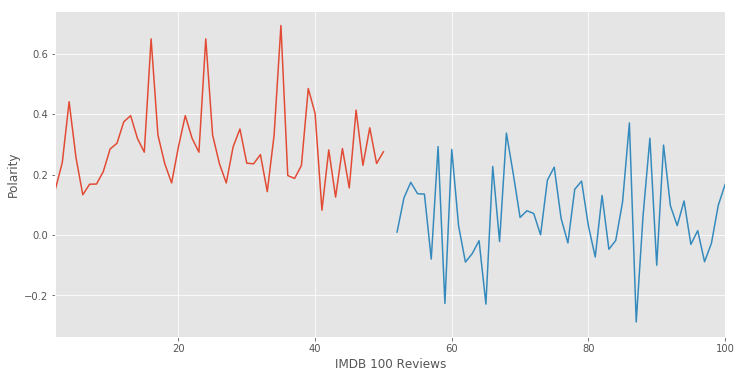

In [8]:
print imdb[['ratings','polarity','subjectivity']].corr()

ax = imdb['polarity'][1:50].plot(figsize=(12, 6))
ax = imdb['polarity'][51:100].plot(figsize=(12, 6))
ax.set_xlabel("IMDB 100 Reviews", fontsize=12)
ax.set_ylabel("Polarity", fontsize=12)
plt.show()


In [13]:
print imdb[['ratings','polarity']].corr()

           ratings  polarity
ratings   1.000000  0.654353
polarity  0.654353  1.000000


In [10]:
 imdb['polarity'][1:5]

2    0.152778
3    0.240171
4    0.441667
5    0.257593
Name: polarity, dtype: float64

In [12]:
text = " this is a awesome review , but i would consider this as pathetic"
blob = TextBlob(text)

TextBlob(unicode(text, errors='ignore')).sentiment.subjectivity

1.0

### Stopwords = [ NLTK stopwords + Extended words from multiple iterations of text analysis ) 

In [13]:
stop_words = nltk.corpus.stopwords.words('english')
extended_stopwords = ['\'ll','\'d','\'m','\'re','\'s','\'ve','ca n\'t','r','n\'t','ca','see','get','movies','movie','go','say','come','many','another','could','would','made','really','want','even','odd','films','plot','ever','actually','also','movie','film']
stopwords = stop_words + extended_stopwords

print stopwords

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u


###  Document Term Matrix using TF-IDF weighing scheme ( unigrams & bigrams ) 


In [15]:
term_idf_vectorizer       = TfidfVectorizer(max_df=0.9, max_features=2000,min_df=0.2, stop_words=stopwords, use_idf=True, tokenizer=tokenize, ngram_range=(1,1))
%time term_idf_matrix     = term_idf_vectorizer.fit_transform(imdb.reviews) 
term_idf_feature_names    = term_idf_vectorizer.get_feature_names()
print (term_idf_matrix).shape

CPU times: user 380 ms, sys: 20 ms, total: 400 ms
Wall time: 377 ms
(100, 42)


### TF-IDF Features on model params  ( min_df = 0.3 , max_df = 0.9 )

In [16]:
print term_idf_feature_names

tfidf = zip(term_idf_vectorizer.get_feature_names(),np.asarray(term_idf_matrix.sum(axis=0)).ravel())
term_idf_frequency = sorted(tfidf,key=lambda x: x[1],reverse=True)
term_idf_frequency



[u'acting', u'best', u'better', u'cameron', u'characters', u'dicaprio', u'disaster', u'effects', u'every', u'first', u'good', u'great', u'hours', u'jack', u'james', u'kate', u'know', u'leonardo', u'life', u'like', u'love', u'make', u'much', u'never', u'one', u'people', u'rose', u'seen', u'ship', u'sinking', u'special', u'still', u'story', u'think', u'time', u'times', u'titanic', u'two', u'watch', u'way', u'well', u'winslet']


[(u'titanic', 17.626590222509247),
 (u'one', 13.211957745078777),
 (u'love', 12.230488865533097),
 (u'people', 12.013901397062293),
 (u'ship', 11.836631605644003),
 (u'time', 11.31619812623377),
 (u'story', 11.090597352939504),
 (u'like', 10.162975853455603),
 (u'cameron', 9.8618963430581292),
 (u'best', 8.6579386437821189),
 (u'rose', 8.6398108245288903),
 (u'jack', 8.4676706001685051),
 (u'good', 7.8338524573719317),
 (u'effects', 7.7517857502390877),
 (u'great', 7.6691982141145605),
 (u'james', 7.6027791024468625),
 (u'winslet', 7.5396571444955027),
 (u'seen', 7.5145752695694243),
 (u'never', 7.2983087567258087),
 (u'every', 6.9948687318212093),
 (u'watch', 6.8684168722304868),
 (u'two', 6.7539253740925851),
 (u'special', 6.7355732010118619),
 (u'think', 6.6984485126159088),
 (u'dicaprio', 6.6326902837130888),
 (u'acting', 6.5874552092916812),
 (u'much', 6.5381385757945516),
 (u'first', 6.5276457965125765),
 (u'kate', 6.4983942984604077),
 (u'way', 6.3407714589391393),
 (u'well', 6.

###  Document Term Matrix using Term Frequency (TF)  weighing scheme ( unigrams & bigrams ) 

In [18]:
count_vectorizer    = CountVectorizer(max_df=0.9, max_features=2000,min_df=0.2, stop_words=stopwords, tokenizer=tokenize, ngram_range=(1,2))
%time term_frequency_matrix = count_vectorizer.fit_transform(imdb.reviews) 
term_frequency_feature_names    = count_vectorizer.get_feature_names()
print (term_frequency_matrix).shape 

CPU times: user 416 ms, sys: 16 ms, total: 432 ms
Wall time: 416 ms
(100, 47)


### Term Frequency  Features on model params  ( min_df = 0.3 , max_df = 0.9 )

In [19]:
print term_frequency_feature_names

tf = zip(count_vectorizer.get_feature_names(),np.asarray(term_frequency_matrix.sum(axis=0)).ravel())
term_frequency = sorted(tf,key=lambda x: x[1],reverse=True)
term_frequency

[u'acting', u'best', u'better', u'cameron', u'characters', u'dicaprio', u'disaster', u'effects', u'every', u'first', u'good', u'great', u'hours', u'jack', u'james', u'james cameron', u'kate', u'kate winslet', u'know', u'leonardo', u'leonardo dicaprio', u'life', u'like', u'love', u'love story', u'make', u'much', u'never', u'one', u'people', u'rose', u'seen', u'ship', u'sinking', u'special', u'special effects', u'still', u'story', u'think', u'time', u'times', u'titanic', u'two', u'watch', u'way', u'well', u'winslet']


[(u'titanic', 182),
 (u'love', 110),
 (u'one', 109),
 (u'ship', 103),
 (u'story', 98),
 (u'time', 94),
 (u'people', 84),
 (u'cameron', 81),
 (u'like', 76),
 (u'rose', 65),
 (u'jack', 61),
 (u'james', 58),
 (u'best', 55),
 (u'winslet', 54),
 (u'effects', 51),
 (u'dicaprio', 47),
 (u'good', 47),
 (u'great', 46),
 (u'love story', 46),
 (u'well', 43),
 (u'james cameron', 42),
 (u'kate', 42),
 (u'much', 42),
 (u'never', 42),
 (u'seen', 42),
 (u'special', 42),
 (u'every', 40),
 (u'think', 40),
 (u'sinking', 39),
 (u'make', 38),
 (u'watch', 37),
 (u'characters', 36),
 (u'special effects', 36),
 (u'two', 36),
 (u'still', 34),
 (u'acting', 33),
 (u'kate winslet', 32),
 (u'way', 31),
 (u'better', 30),
 (u'first', 30),
 (u'know', 30),
 (u'life', 29),
 (u'leonardo', 28),
 (u'disaster', 27),
 (u'hours', 26),
 (u'times', 26),
 (u'leonardo dicaprio', 20)]

### Topic extraction with Non-negative Matrix Factorization using TF-IDF Features 

In [24]:
# Fit the NMF model
%time nmf = NMF(n_components=3, random_state=1,alpha=.1, l1_ratio=.5).fit(term_idf_matrix)

print("\nFitting the Non-negative Matrix Factorization model with tf-idf features: \n")
print_top_words(nmf, term_idf_feature_names, 10)

CPU times: user 64 ms, sys: 124 ms, total: 188 ms
Wall time: 58.8 ms

Fitting the Non-negative Matrix Factorization model with tf-idf features: 

Topic #0:
titanic jack rose ship winslet well story dicaprio love kate
Topic #1:
time people one like think every watch love seen titanic
Topic #2:
effects special cameron good characters james make hours sinking story
()


### Topic extraction with Latent Dirichlet Allocation using TF Features 

In [27]:
lda = LatentDirichletAllocation(n_topics=2, max_iter=10,learning_method='online',learning_offset=10.,random_state=1)
%time lda.fit(term_frequency_matrix)
print("\nTopics using Latent Dirichlet Allocation model with Term frequencies: \n")
print_top_words(lda, term_frequency_feature_names, 10)

CPU times: user 384 ms, sys: 0 ns, total: 384 ms
Wall time: 389 ms

Topics using Latent Dirichlet Allocation model with Term frequencies: 

Topic #0:
titanic ship love rose jack story one cameron never james
Topic #1:
titanic time one people love like story cameron effects best
()


###  LDA Topic modeling using only Bigram features  based on frequency ( avoid unigram noise ) 

In [28]:
bigram_vectorizer    = CountVectorizer(max_df=0.9, max_features=200,min_df=0.06, stop_words=stopwords, tokenizer=tokenize, ngram_range=(2,3))
%time dtm_bigram_matrix = bigram_vectorizer.fit_transform(imdb.reviews) 
bigram_frequency_feature_names    = bigram_vectorizer.get_feature_names()
print (dtm_bigram_matrix).shape
print ("\n Bigram Features based on Term Frequency \n ")
tf = zip(bigram_vectorizer.get_feature_names(),np.asarray(dtm_bigram_matrix.sum(axis=0)).ravel())
bigram_term_frequency = sorted(tf,key=lambda x: x[1],reverse=True)
bigram_term_frequency

CPU times: user 380 ms, sys: 12 ms, total: 392 ms
Wall time: 374 ms
(100, 26)

 Bigram Features based on Term Frequency 
 


[(u'love story', 46),
 (u'james cameron', 42),
 (u'special effects', 36),
 (u'kate winslet', 32),
 (u'leonardo dicaprio', 20),
 (u'jack rose', 18),
 (u'billy zane', 17),
 (u'kathy bates', 12),
 (u'first time', 11),
 (u'jack dawson', 10),
 (u'every time', 9),
 (u'ship sinking', 9),
 (u'celine dion', 8),
 (u'gloria stuart', 8),
 (u'sinking ship', 8),
 (u'dicaprio winslet', 7),
 (u'james horner', 7),
 (u'one best', 7),
 (u'best picture', 6),
 (u'dicaprio kate', 6),
 (u'dicaprio kate winslet', 6),
 (u'fall love', 6),
 (u'falls love', 6),
 (u'much money', 6),
 (u'ship sink', 6),
 (u'year old', 6)]

In [16]:
#from IPython.display import Image
#Image(filename='up_imdb_review.png')

###  Topics = 5 , Displaying top 10 words based on probability 

In [29]:
lda = LatentDirichletAllocation(n_topics=2, max_iter=4,learning_method='batch',learning_offset=50.,random_state=0)
%time lda.fit(dtm_bigram_matrix)
print("\nTopics using Latent Dirichlet Allocation model with Term frequencies: \n")
print_top_words(lda, bigram_frequency_feature_names,5)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 93.2 ms

Topics using Latent Dirichlet Allocation model with Term frequencies: 

Topic #0:
james cameron kate winslet billy zane leonardo dicaprio kathy bates
Topic #1:
love story special effects jack rose james cameron leonardo dicaprio
()


###  Recommendation based on movie attributes [ Titanic( 1997)  ] 

    [ Floating house, Paradise falls, Thousands Balloons, Old man & Boy , Retirement Home flying to South America, Boy scout, bird = Kevin ] 
     
     Very innovative animation movie ( may be better than toy story ) which will attract young and old because of its characters. The director needs to retain the theme where he effectively utilized talking animals, explorer , adventures, bonding ( young kid with old man ) which got him success. 
     
     Pixar , Disney should make more animation movies with actors Edward Asner , Christopher Plummer & Jordan Nagai
    

In [33]:
term_idf_vectorizer       = TfidfVectorizer(max_df=0.9, max_features=2000,min_df=0.2, stop_words=stopwords, use_idf=False, tokenizer=tokenize, ngram_range=(1,1))
%time term_idf_matrix     = term_idf_vectorizer.fit_transform(imdb.reviews) 
term_idf_feature_names    = term_idf_vectorizer.get_feature_names()
print (term_idf_matrix).shape

CPU times: user 300 ms, sys: 12 ms, total: 312 ms
Wall time: 298 ms
(100, 42)


In [34]:
print term_frequency_feature_names

tf = zip(count_vectorizer.get_feature_names(),np.asarray(term_frequency_matrix.sum(axis=0)).ravel())
term_frequency = sorted(tf,key=lambda x: x[1],reverse=True)
term_frequency

[u'acting', u'best', u'better', u'cameron', u'characters', u'dicaprio', u'disaster', u'effects', u'every', u'first', u'good', u'great', u'hours', u'jack', u'james', u'james cameron', u'kate', u'kate winslet', u'know', u'leonardo', u'leonardo dicaprio', u'life', u'like', u'love', u'love story', u'make', u'much', u'never', u'one', u'people', u'rose', u'seen', u'ship', u'sinking', u'special', u'special effects', u'still', u'story', u'think', u'time', u'times', u'titanic', u'two', u'watch', u'way', u'well', u'winslet']


[(u'titanic', 182),
 (u'love', 110),
 (u'one', 109),
 (u'ship', 103),
 (u'story', 98),
 (u'time', 94),
 (u'people', 84),
 (u'cameron', 81),
 (u'like', 76),
 (u'rose', 65),
 (u'jack', 61),
 (u'james', 58),
 (u'best', 55),
 (u'winslet', 54),
 (u'effects', 51),
 (u'dicaprio', 47),
 (u'good', 47),
 (u'great', 46),
 (u'love story', 46),
 (u'well', 43),
 (u'james cameron', 42),
 (u'kate', 42),
 (u'much', 42),
 (u'never', 42),
 (u'seen', 42),
 (u'special', 42),
 (u'every', 40),
 (u'think', 40),
 (u'sinking', 39),
 (u'make', 38),
 (u'watch', 37),
 (u'characters', 36),
 (u'special effects', 36),
 (u'two', 36),
 (u'still', 34),
 (u'acting', 33),
 (u'kate winslet', 32),
 (u'way', 31),
 (u'better', 30),
 (u'first', 30),
 (u'know', 30),
 (u'life', 29),
 (u'leonardo', 28),
 (u'disaster', 27),
 (u'hours', 26),
 (u'times', 26),
 (u'leonardo dicaprio', 20)]